

Details of columns:

1. **Date**: The date of the recorded data.
2. **SPX**: The S&P 500 index value on the given date.
3. **GLD**: The price of gold (GLD ETF) on the given date.
4. **USO**: The price of crude oil (USO ETF) on the given date.
5. **SLV**: The price of silver (SLV ETF) on the given date.
6. **EUR/USD**: The exchange rate between the Euro and US Dollar on the given date.

In [1]:
#importing all the importatnt libraries we'll be using in this project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
#loading the dataset

df = pd.read_csv(r"/content/gold_price_data.csv")
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [3]:
df.shape

(2290, 6)

In [4]:
df.columns

Index(['Date', 'SPX', 'GLD', 'USO', 'SLV', 'EUR/USD'], dtype='object')

In [5]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [6]:
#data preprocessing

df.isnull().sum()

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


Luckily no null values.

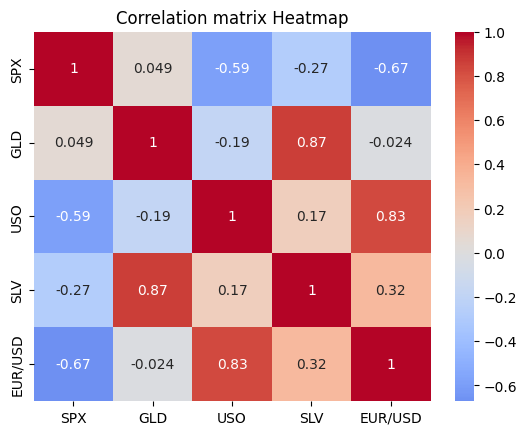

In [7]:
#let's check for correlation between columns.
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation matrix Heatmap")
plt.show()

* We can see there few columns are highly correlated.
* We'll be removing SLV since it is highly correlated with GLD.

In [8]:
df.drop('SLV', axis=1, inplace=True)

In [9]:
#Data Wrangling (setting the date as index)

df.set_index("Date", inplace=True)

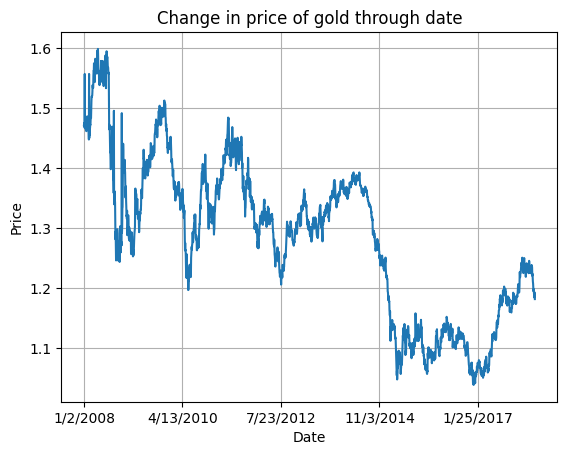

In [10]:
df['EUR/USD'].plot()
plt.title("Change in price of gold through date")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()

We can see a lot of noise in the data we need to make it smooth for a smooth graph.

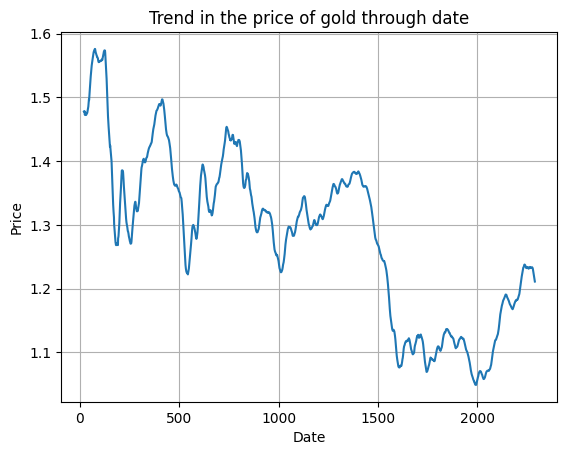

In [11]:
df['price_trend'] = df['EUR/USD'].rolling(window=20).mean()
df.reset_index("Date", inplace=True)
#Since we have used rooling window the first 20 values will be NaN so we need to avoid those datapoints
df["price_trend"].loc[20:].plot()
plt.title("Trend in the price of gold through date")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()

Now the data looks less noisy, hence we can move forward with analyzing.

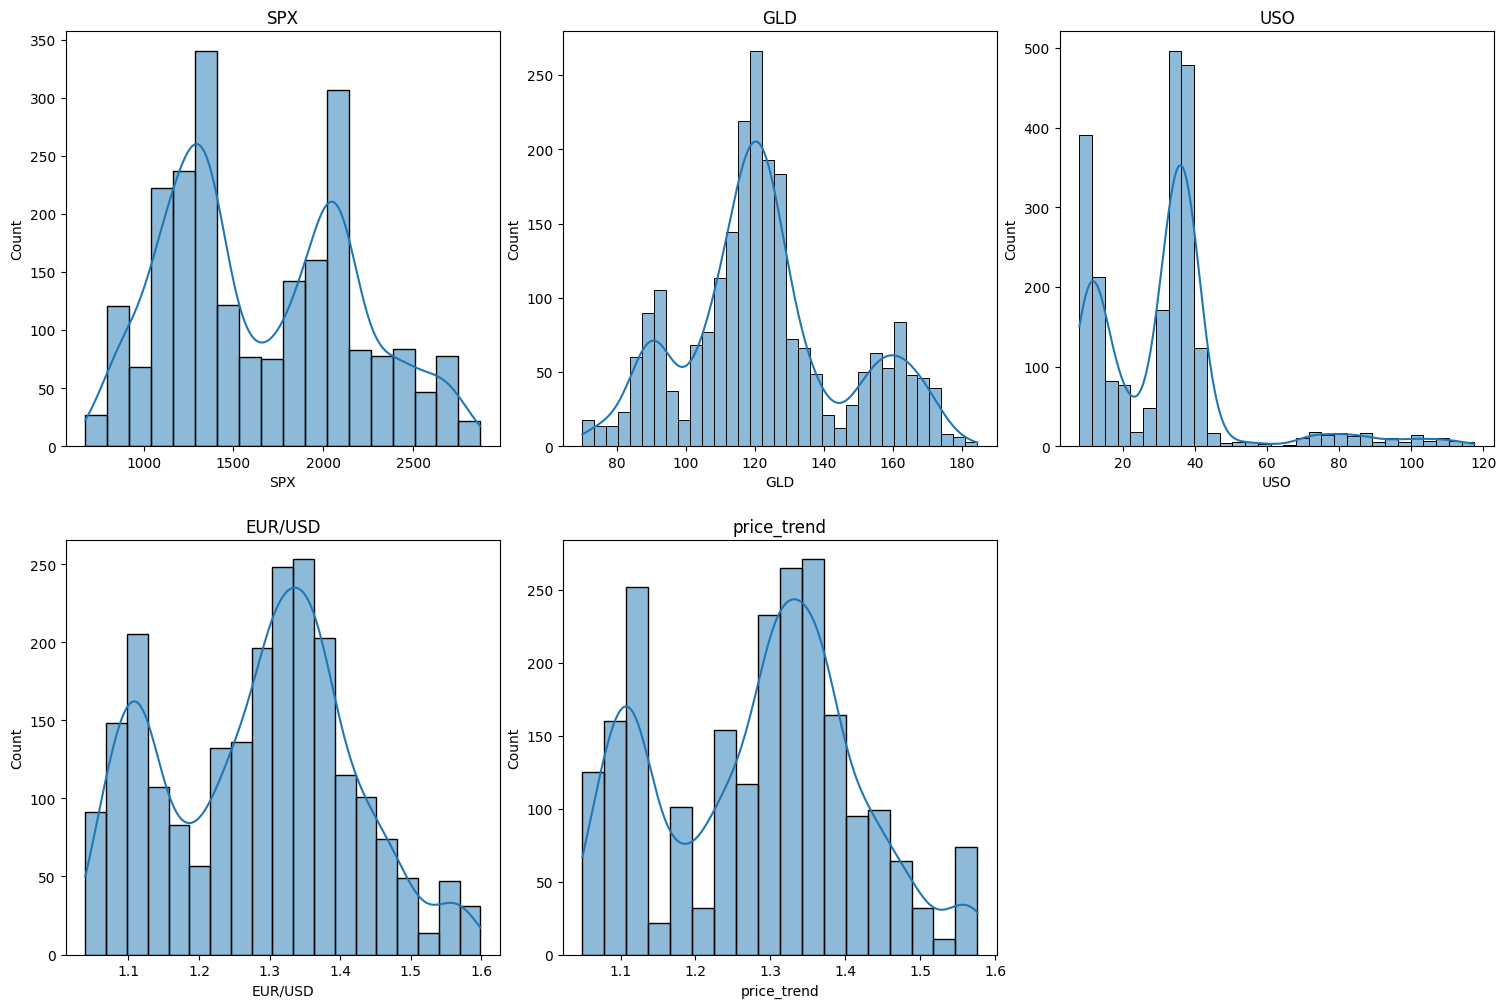

In [12]:
fig = plt.figure(figsize=(15, 10))
temp = df.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2,3,i+1)
    sns.histplot(data = df, x=item, kde=True)
    plt.title(f"{item}")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

We can observe the distribution of data in all the columns, we can see that none of the columns are exaclty symmetric in nature.

In [13]:
# Let's check the skewness of all the columns
print(df.drop("Date", axis=1).skew(axis=0, skipna=True))

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


We can observe that USO is the most skewed so let's work on that using squre root transformation.

In [14]:
df['USO'] = df['USO'].apply(lambda x: np.sqrt(x))

In [15]:
#uncomment and print this to confirm the skewness of the USO column.

# print(df.drop("Date", axis=1).skew(axis=0, skipna=True))

Now let's handle the outliers of the columns using boxplot

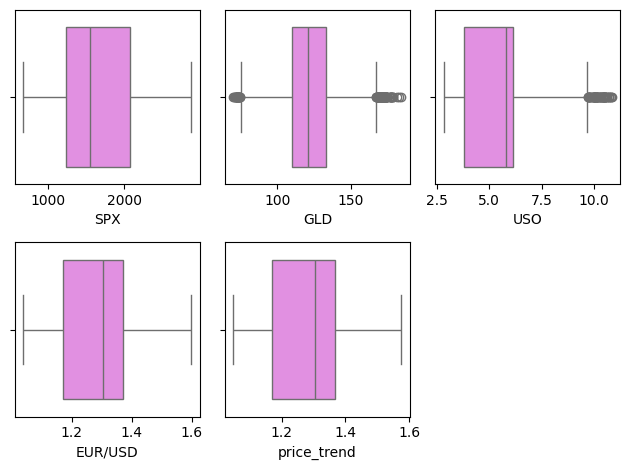

In [16]:
# fig = figure(figsize = (15, 10))
df_cols = df.columns[1:]
df_cols
for i, col in enumerate(df_cols) :
  plt.subplot(2,3,i+1)
  sns.boxplot(data=df, x=col, color='violet')
plt.tight_layout()
plt.show()


GLD and USO column has a lot of outliers.

In [17]:
def remove_outliers(df, column):                  #function to remove outliers
    Q1 = df[column].quantile(0.25)                #defining Q1
    Q3 = df[column].quantile(0.75)                #defining Q3
    IQR = Q3 - Q1                                 #defining IQR
    lower_bound = Q1 - 1.5 * IQR                  #calculating lower bound
    upper_bound = Q3 + 1.5 * IQR                  #calculating upper bound
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]    #returning all the rows with lesser than lower bound and more than upper bound

print("Dataset size before removing outliers: ", df.shape)
for col in df.columns[1:]:
    df = remove_outliers(df, col)                 # calling the function
print("Dataset size after removing outliers: ", df.shape)

Dataset size before removing outliers:  (2290, 6)
Dataset size after removing outliers:  (2108, 6)


In [18]:
from sklearn.model_selection import train_test_split
#feature extraction
x = df.drop(['Date','EUR/USD'], axis=1)
y = df['EUR/USD']

#splitting data for training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1686, 4), (422, 4), (1686,), (422,))

In [19]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso

imputer = SimpleImputer(strategy='mean')

x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

poly = PolynomialFeatures(degree=2)

lasso = Lasso()

param_grid = {'lasso__alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 30, 40]}

pipeline = make_pipeline(poly, lasso)

lasso_grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=3)

lasso_grid_search.fit(x_train, y_train)

y_pred = lasso_grid_search.predict(x_train)

print("R-squared : ",r2_score(y_train, y_pred))
print("Best Parameter values : ", lasso_grid_search.best_params_)
print("Best Score : ", lasso_grid_search.best_score_)

R-squared :  0.9703458850681898
Best Parameter values :  {'lasso__alpha': 0.0001}
Best Score :  0.9689003306093653


R-squared :  1.0

Best Parameter values :  {'lasso__alpha': 0.0001}

Best Score :  1.0

In [21]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators':[50, 80, 100],
               'max_depth':[3, 5, 7]}

rfr = RandomForestRegressor()
rfr_grid_search = GridSearchCV(rfr, param_grid, scoring='r2', cv=2)

rfr_grid_search.fit(x_train, y_train)

print('Best parameter values : ', rfr_grid_search.best_params_)
print("Best Score : ", rfr_grid_search.best_score_)
print("R-squared : ", r2_score(y_test, rfr_grid_search.predict(x_test)))

Best parameter values :  {'max_depth': 7, 'n_estimators': 50}
Best Score :  0.9762462187547755
R-squared :  0.979188545114514


In [22]:
df.columns

Index(['Date', 'SPX', 'GLD', 'USO', 'EUR/USD', 'price_trend'], dtype='object')

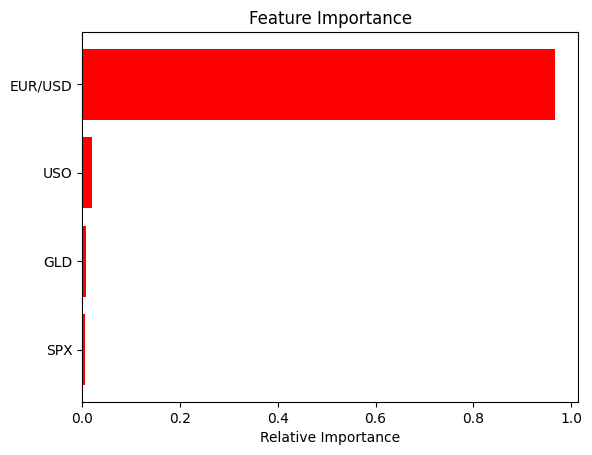

In [23]:
features = df.drop(['Date'], axis=1).columns

importances = rfr_grid_search.best_estimator_.feature_importances_

indices = np.argsort(importances)

plt.title("Feature Importance")

plt.barh(range(len(indices)), importances[indices], color='red',align='center')

plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [24]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(x_train, y_train)
print("XGBoost Accuuracy : ",r2_score(y_train, xgb.predict(x_train)))
print('XGBoost Accuracy on test data = ', r2_score(y_test, xgb.predict(x_test)))

XGBoost Accuuracy :  0.9994582909361239
XGBoost Accuracy on test data =  0.9874658818943237


We can say XGBoost is the most accurate among all the three models, hence our model is an excellent model.

Thank you for going through my work till the end, feel free to get in touch if you have any questions... :)